# OBJECTIVE :- Built LSTM model on Amazon Fine Food Reviews

In [2]:
# Installing package
!pip install gensim

# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

## Loading Data from Reviews.CSV file in Google Drive

In [0]:
# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Downloading a file based on its file ID
#file_id = 'REPLACE_WITH_YOUR_FILE_ID'
#downloaded = drive.CreateFile({'id': file_id})
downloaded = drive.CreateFile({'id':'1pHPZn0WOyqUGfBTLSuBw1ggKe_DOaZdw'}) 
downloaded.GetContentFile('Reviews.CSV')

# Getting data into a dataframe
df = pd.read_csv('Reviews.CSV')

In [6]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
# Eliminating neutral reviews i.e. those reviews with Score = 3
filtered_data = df[df['Score'] != 3]

# Converting Score variables to binary class variable (1-positive review and 0-negative review)
# Give reviews with Score>3 a positive rating (1) , and reviews with a score<3 a negative rating (0).
def polarity(x):
    if x < 3:
        return 0
    return 1

# Applying polarity function on Score column of filtered_data
filtered_data['Score'] = filtered_data['Score'].map(polarity)

print(filtered_data.shape)
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


NOTE :- In above table , in Score column 1 = positive review and 0 = negative review

## Data Cleaning: Deduplication

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

# Removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

print(final.shape)
final[30:50]

(364171, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
150492,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,1,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
150499,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,1,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...
150498,150499,0006641040,A3E7R866M94L0C,"L. Barker ""simienwolf""",2,2,1,1065830400,Can't explain why,This book has been a favorite of mine since I ...
515425,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,1,1332547200,The best drink mix,This product by Archer Farms is the best drink...
24750,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
24749,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
308076,308077,2841233731,A3QD68O22M2XHQ,LABRNTH,0,0,1,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...
171160,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,1,1229385600,Excellent treats,I have been feeding my greyhounds these treats...
171159,171160,7310172001,A74C7IARQEM1R,stucker,0,0,1,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...


OBSERVATION :- Here books with ProductId - 0006641040 and 2841233731 are also there so we have to remove all these rows with these ProductIds from the data

In [9]:
final = final[final['ProductId'] != '2841233731']
final = final[final['ProductId'] != '0006641040']
final.shape

(364136, 10)


## Text Preprocessing: Stemming, stop-word removal and Lemmatization.¶


In [10]:
# Downloading stopwords
nltk.download('stopwords')

#set of stopwords in English
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
words_to_keep = set(('not'))
stop -= words_to_keep
#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

 #function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
#Code for removing HTML tags , punctuations . Code for removing stopwords . Code for checking if word is not alphanumeric and
# also greater than 2 . Code for stemmimg and also to convert them to lowercase letters 
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [12]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=final_string  
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (364136, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
515425,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,1,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...
24750,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
24749,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
171160,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,1,1229385600,Excellent treats,I have been feeding my greyhounds these treats...,feed greyhound treat year hound littl finicki ...
171159,171160,7310172001,A74C7IARQEM1R,stucker,0,0,1,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...,one product welsh terrier eat sophi food alerg...


## Converting this data as IMDB dataset

In [13]:
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

x = time_sorted_data['CleanedText'].values
y = time_sorted_data['Score']

# Finding all words in the vocabulary
count_vect = CountVectorizer() 
count_vect.fit(x)

vocabulary = count_vect.get_feature_names()
print('No. of words in the Vocabulary : ',len(vocabulary))

No. of words in the Vocabulary :  71611


In [0]:
# Storing all words in the dictionary (words as keys and index as values)
corpus = dict()
ind = 0
for sent in x:
  for word in sent.split():
    corpus.setdefault(word,[])
    corpus[word].append(ind)
    ind += 1

# Getting frequency for each word of vocabulary and storing it in a list
freq = []
for w in vocabulary:
  freq.append(len(corpus[w]))


In [0]:
# Getting Index for each word in the vocabulary
# Sorting frequencies in decreasing order
inc_index =np.argsort(np.array(freq))[::-1]

# Allocating ranks to words of vocabulary in decreasing order of frequency and storing words in a dictionary
word_rank = dict()
rank = 1
for i in inc_index:
  word_rank[vocabulary[i]] = rank
  rank +=1  

In [0]:
# Converting full data into imdb format
data = []
for sent in x:
  row = []
  for word in sent.split():
    if(len(word)>1):
      row.append(word_rank[word])
  data.append(row)

# Splitting the data into 50-50 train_data and test_data
from sklearn.model_selection import train_test_split 
X_train, X_test, Y_train, Y_test = train_test_split(data, y, test_size=0.5, random_state=42)    

In [17]:
print("No. of datapoints in X_train :",len(X_train))
print("No. of datapoints in X_test :",len(X_test))
print("Shape of Y_train :",Y_train.shape)
print("Shape of Y_test :",Y_test.shape)

No. of datapoints in X_train : 182068
No. of datapoints in X_test : 182068
Shape of Y_train : (182068,)
Shape of Y_test : (182068,)


In [18]:
# Importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [19]:
# truncate and/or pad input sequences
max_review_length = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(182068, 100)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 152
  30 241  93 877 313 117  14 329  47  67]


In [0]:
# this function is used draw Binary Crossentropy Loss VS No. of epochs plot
def plt_dynamic(x, vy, ty):
  plt.figure(figsize=(10,5))
  plt.plot(x, vy, 'b', label="Validation Loss")
  plt.plot(x, ty, 'r', label="Train Loss")
  plt.xlabel('Epochs') 
  plt.ylabel('Binary Crossentropy Loss')
  plt.title('\nBinary Crossentropy Loss VS Epochs')
  plt.legend()
  plt.grid()
  plt.show()

## (1) RNN with 1 LSTM layer

In [22]:
# create the model
embedding_vecor_length = 32

# Initialising the model
model_1 = Sequential()

# Adding embedding
model_1.add(Embedding(len(vocabulary), embedding_vecor_length, input_length=max_review_length))

# Adding Dropout
model_1.add(Dropout(0.2))

# Adding first LSTM layer
model_1.add(LSTM(100))

# Adding Dropout
model_1.add(Dropout(0.2))

# Adding output layer
model_1.add(Dense(1, activation='sigmoid'))

# Printing the model summary
print(model_1.summary())

# Compiling the model
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the data to the model
history_1 = model_1.fit(X_train, Y_train, nb_epoch=10, batch_size=512 ,verbose=1,validation_data=(X_test, Y_test))



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           2291552   
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 2,344,853
Trainable params: 2,344,853
Non-trainable params: 0
_________________________________________________________________
None
Train on 182068 samples, validate on 182068 samples
Epoch 1/10
182068/182068 [==============================] - 105s 577us/step

Accuracy: 91.93%


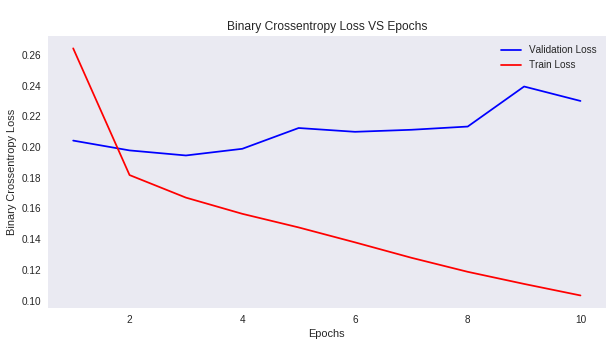

In [23]:
# Final evaluation of the model
scores = model_1.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Test and train accuracy of the model
model_1_test = scores[1]
model_1_train = max(history_1.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,11))

# Validation loss
vy = history_1.history['val_loss']
# Training loss
ty = history_1.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

## (2). RNN with 2 LSTM layers

In [24]:
# create the model
embedding_vecor_length = 32

# Initialising the model
model_2 = Sequential()

# Adding embedding
model_2.add(Embedding(len(vocabulary), embedding_vecor_length, input_length=max_review_length))

# Adding first LSTM layer
model_2.add(LSTM(100,return_sequences=True, dropout=0.4, recurrent_dropout=0.4))

# Adding second LSTM layer
model_2.add(LSTM(100, dropout=0.4, recurrent_dropout=0.4))

# Adding output layer
model_2.add(Dense(1, activation='sigmoid'))

# Printing the model summary
print(model_2.summary())

# Compiling the model
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the data to the model
history_2 = model_2.fit(X_train, Y_train, nb_epoch=10, batch_size=512 ,verbose=1,validation_data=(X_test, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 32)           2291552   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 100)          53200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 2,425,253
Trainable params: 2,425,253
Non-trainable params: 0
_________________________________________________________________
None
Train on 182068 samples, validate on 182068 samples
Epoch 1/10
182068/182068 [==============================] - 241s 1ms/step - loss: 0.2771 - acc: 0.8941 - val_loss: 0.2046 - val_acc: 0.9198
Epoch 2/10
182068/182068 [==============================] - 239s 1m

Accuracy: 91.97%


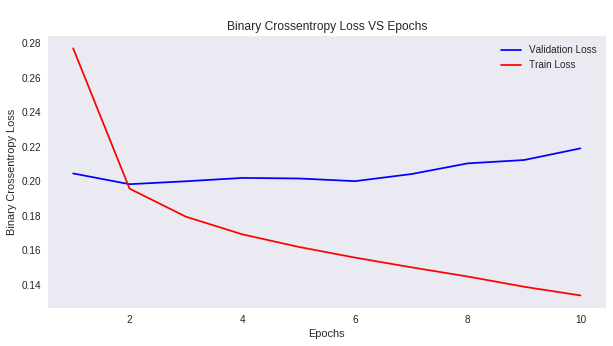

In [25]:
# Final evaluation of the model
scores = model_2.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Test and train accuracy of the model
model_2_test = scores[1]
model_2_train = max(history_2.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,11))

# Validation loss
vy = history_2.history['val_loss']
# Training loss
ty = history_2.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

## (3). RNN with 3 LSTM layers

In [27]:
# create the model
embedding_vecor_length = 32

# Initialising the model
model_3 = Sequential()

# Adding embedding
model_3.add(Embedding(len(vocabulary), embedding_vecor_length, input_length=max_review_length))

# Adding first LSTM layer
model_3.add(LSTM(100,return_sequences=True, dropout=0.4, recurrent_dropout=0.4))

# Adding second LSTM layer
model_3.add(LSTM(100,return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

# Adding third LSTM layer
model_3.add(LSTM(100, dropout=0.4, recurrent_dropout=0.4))

# Adding output layer
model_3.add(Dense(1, activation='sigmoid'))

# Printing the model summary
print(model_3.summary())

# Compiling the model
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the data to the model
history_3 = model_3.fit(X_train, Y_train, nb_epoch=7, batch_size=1024 ,verbose=1,validation_data=(X_test, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 32)           2291552   
_________________________________________________________________
lstm_8 (LSTM)                (None, 100, 100)          53200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 2,505,653
Trainable params: 2,505,653
Non-trainable params: 0
_________________________________________________________________
None
Train on 182068 samples, validate on 182068 samples
Epoch 1/7
182068/182068 [==============================] - 195s 1ms/step - 

Accuracy: 92.17%


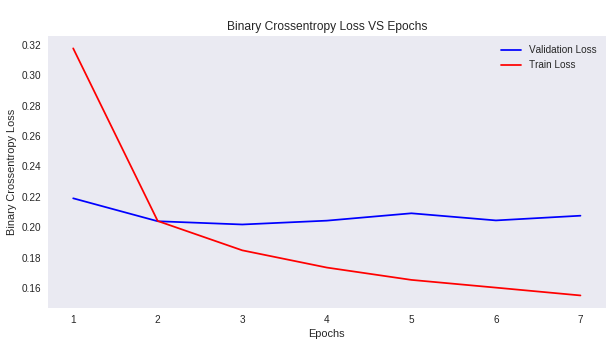

In [28]:
# Final evaluation of the model
scores = model_3.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Test and train accuracy of the model
model_3_test = scores[1]
model_3_train = max(history_3.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,8))

# Validation loss
vy = history_3.history['val_loss']
# Training loss
ty = history_3.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

## (4). RNN with 4 LSTM layers

In [30]:
# create the model
embedding_vecor_length = 64

# Initialising the model
model_4 = Sequential()

# Adding embedding
model_4.add(Embedding(len(vocabulary), embedding_vecor_length, input_length=max_review_length))

# Adding first LSTM layer
model_4.add(LSTM(120,return_sequences=True, dropout=0.6, recurrent_dropout=0.6))

# Adding second LSTM layer
model_4.add(LSTM(100,return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

# Adding third LSTM layer
model_4.add(LSTM(80,return_sequences=True, dropout=0.4, recurrent_dropout=0.4))

# Adding fourth LSTM layer
model_4.add(LSTM(60, dropout=0.3, recurrent_dropout=0.3))

# Adding output layer
model_4.add(Dense(1, activation='sigmoid'))

# Printing the model summary
print(model_4.summary())

# Compiling the model
model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the data to the model
history_4 = model_4.fit(X_train, Y_train, nb_epoch=8, batch_size=2048 ,verbose=1,validation_data=(X_test, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 64)           4583104   
_________________________________________________________________
lstm_15 (LSTM)               (None, 100, 120)          88800     
_________________________________________________________________
lstm_16 (LSTM)               (None, 100, 100)          88400     
_________________________________________________________________
lstm_17 (LSTM)               (None, 100, 80)           57920     
_________________________________________________________________
lstm_18 (LSTM)               (None, 60)                33840     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 61        
Total params: 4,852,125
Trainable params: 4,852,125
Non-trainable params: 0
_________________________________________________________________


Accuracy: 92.18%


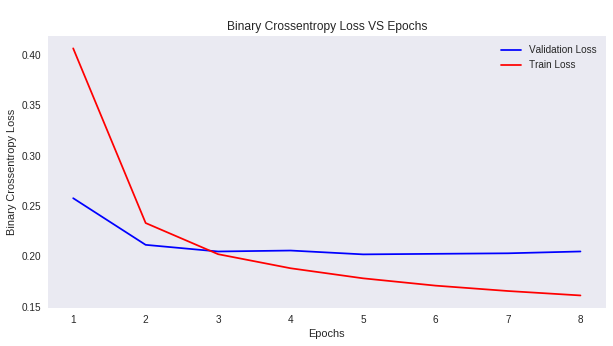

In [31]:
# Final evaluation of the model
scores = model_4.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Test and train accuracy of the model
model_4_test = scores[1]
model_4_train = max(history_4.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,9))

# Validation loss
vy = history_4.history['val_loss']
# Training loss
ty = history_4.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

## CONCLUSION

## (a). Procedure Followed :



1.   Load Amazon Fine Food Reviews dataset
2.   Perform text pre-processing
3.  Sort the dataset on the basis of time and after that find vocabulary for all the reviews in the dataset
4.  Now compute frequencies for each word of vocabulary
5.  Index each word in the decreasing order of frequencies (Word with max frequency will have rank 1 or index 1)
6.  Convert the dataset into imdb dataset format
7.  Split whole dataset into 50-50 for training_data and test_data randomly
8.  Now pad or truncate each review intpo sequences of length 100
9.  Now implement RNN with 1 , 2 ,3 and 4 LSTM layers
10. Find accuracy for each
11. Draw Binary Crossentropy Loss VS No.of Epochs plot 



## (b) Table (Different models with their train and test accuracies):

In [33]:
# Installing the library prettytable
!pip install prettytable

# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of models
names = ['RNN With 1 LSTM Layer','RNN With 2 LSTM Layers','RNN With 3 LSTM Layers','RNN With 4 LSTM Layers']

# Training accuracies
train_acc = [model_1_train,model_2_train,model_3_train,model_4_train]

# Test accuracies
test_acc = [model_1_test,model_2_test,model_3_test,model_4_test]

numbering = [1,2,3,4]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+------------------------+--------------------+--------------------+
| S.NO. |         MODEL          | Training Accuracy  |   Test Accuracy    |
+-------+------------------------+--------------------+--------------------+
|   1   | RNN With 1 LSTM Layer  | 0.9612836961699912 | 0.919315860009658  |
|   2   | RNN With 2 LSTM Layers | 0.9493485950435232 | 0.9196618845705999 |
|   3   | RNN With 3 LSTM Layers | 0.9418843509005513 | 0.9217160621306325 |
|   4   | RNN With 4 LSTM Layers | 0.9391600942390127 | 0.921792956479109  |
+-------+------------------------+--------------------+--------------------+
